## Dataset Information

This project uses the **Chest X-Ray Images (Pneumonia)** dataset from **Guangzhou Women and Children’s Medical Center**.

- **Data Source:** [Mendeley Data Repository](https://data.mendeley.com/datasets/rscbjbr9sj/2)
- **License:** [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)
- **Citation:** [Cell Journal Publication](http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5)

All chest radiographs were screened for quality control before being graded by expert physicians. This dataset is used to train AI models for pneumonia detection based on chest X-ray imaging.


In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim.lr_scheduler as lr_scheduler

import numpy as np
#from utils import add_noise, evaluate

import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

### Preparing, Loading and Preprocessing data

In [ ]:
for dirname, _, filenames in os.walk('./AI-Medical-Imaging-Recon/data/chest_xray'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return data

def add_noise(img, noise_type="gaussian", std=0.05):
    if noise_type == "gaussian":
        noisy = img + std * np.random.randn(*img.shape)
        return np.clip(noisy, 0, 1)
    return img

class DummyImageDataset(Dataset):
    def __init__(self, clean_data, noise_data):
        self.clean_data = torch.tensor(clean_data, dtype=torch.float32).permute(0, 3, 1, 2)
        self.noise_data = torch.tensor(noise_data, dtype=torch.float32).permute(0, 3, 1, 2)

    def __len__(self):
        return len(self.clean_data)

    def __getitem__(self, idx):
        clean = self.clean_data[idx]
        noisy = self.noise_data[idx]
        return [clean, noisy] 

In [4]:
train = get_training_data('../AI-Medical-Imaging-Recon/data/chest_xray/train')
val = get_training_data('../AI-Medical-Imaging-Recon/data/chest_xray/val')
test = get_training_data('../AI-Medical-Imaging-Recon/data/chest_xray/test')

<Axes: xlabel='count'>

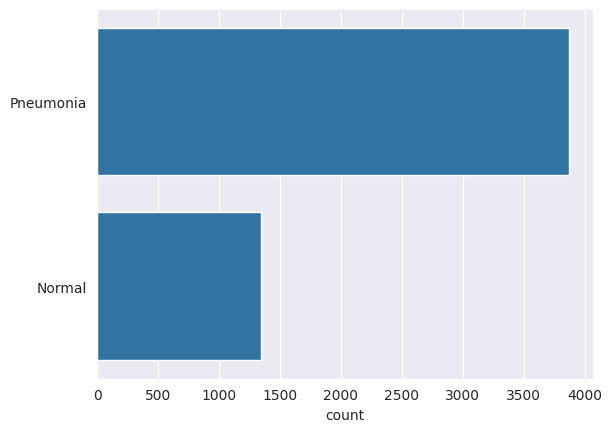

In [16]:
lst_label = []
for i in train:
    if(i[1] == 0):
        lst_label.append("Pneumonia")
    else:
        lst_label.append("Normal")
sns.set_style('darkgrid')
sns.countplot(lst_label) 

Text(0.5, 1.0, 'NORMAL')

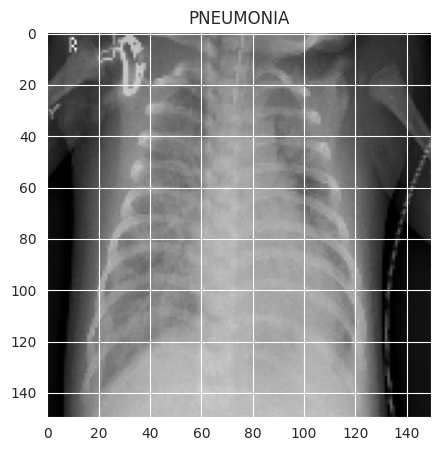

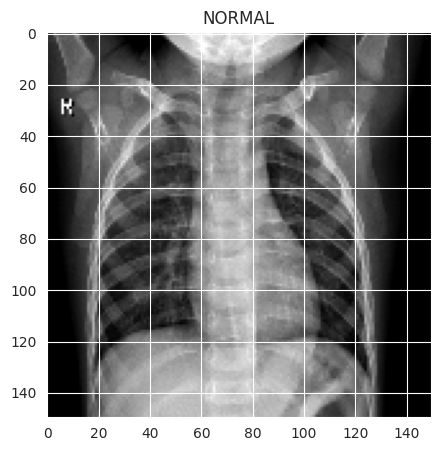

In [17]:
# Visualize checking the data
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [5]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [7]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
x_train_noise = [add_noise(img) for img in x_train]
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
x_val_noise = [add_noise(img) for img in x_val]
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
x_test_noise = [add_noise(img) for img in x_test]
y_test = np.array(y_test)

### Building the Unet model architecture

In [8]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256]):
        super(UNet, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()

        for feature in features:
            self.downs.append(self._block(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(self._block(feature*2, feature))

        self.bottleneck = self._block(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def _block(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = F.max_pool2d(x, 2)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for i in range(0, len(self.ups), 2):
            x = self.ups[i](x)
            skip = skip_connections[i // 2]
            if x.shape != skip.shape:
                x = F.interpolate(x, size=skip.shape[2:])
            x = torch.cat((skip, x), dim=1)
            x = self.ups[i+1](x)

        return self.final_conv(x)


### Train the model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
dataset = DummyImageDataset(x_train, x_train_noise)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

dataset = DummyImageDataset(x_val, x_val_noise)
val_loader = DataLoader(dataset, batch_size=64, shuffle=False)

dataset = DummyImageDataset(x_test, x_test_noise)
test_loader = DataLoader(dataset, batch_size=64, shuffle=False)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [10]:
best_loss = float('inf')
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for clean, noise in train_loader:
        clean = clean.to(device)
        noise = noise.to(device)
        optimizer.zero_grad()
        output = model(noise)

        loss = criterion(output, clean)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for clean, noise in val_loader:
            clean, noise = clean.to(device), noise.to(device)
            output = model(noise)

            loss = criterion(output, clean)
            val_loss += loss.item()

    temp_val_loss = val_loss/len(val_loader)
    print(f"Epoch {epoch+1}, Train Loss: {total_loss/len(train_loader):.5f}, Val Loss: {temp_val_loss:.5f}, Current LR:{scheduler.get_last_lr()[0]:.6f}")

    scheduler.step()

    if temp_val_loss < best_loss:
        torch.save(model.state_dict(), f"/home/goldan/temp_files/AI-Medical-Imaging-Recon/src/checkpoint/model_epoch_{epoch+1}.pth")
        best_loss = temp_val_loss

Epoch 1, Train Loss: 0.07240, Val Loss: 0.00180, Current LR:0.001000
Epoch 2, Train Loss: 0.00122, Val Loss: 0.00090, Current LR:0.001000
Epoch 3, Train Loss: 0.00074, Val Loss: 0.00062, Current LR:0.001000
Epoch 4, Train Loss: 0.00060, Val Loss: 0.00055, Current LR:0.001000
Epoch 5, Train Loss: 0.00056, Val Loss: 0.00052, Current LR:0.001000
Epoch 6, Train Loss: 0.00054, Val Loss: 0.00051, Current LR:0.000500
Epoch 7, Train Loss: 0.00053, Val Loss: 0.00050, Current LR:0.000500
Epoch 8, Train Loss: 0.00053, Val Loss: 0.00049, Current LR:0.000500
Epoch 9, Train Loss: 0.00052, Val Loss: 0.00048, Current LR:0.000500
Epoch 10, Train Loss: 0.00051, Val Loss: 0.00048, Current LR:0.000500
Epoch 11, Train Loss: 0.00050, Val Loss: 0.00047, Current LR:0.000250
Epoch 12, Train Loss: 0.00050, Val Loss: 0.00047, Current LR:0.000250
Epoch 13, Train Loss: 0.00050, Val Loss: 0.00047, Current LR:0.000250
Epoch 14, Train Loss: 0.00049, Val Loss: 0.00046, Current LR:0.000250
Epoch 15, Train Loss: 0.00049

### Evaluate the model with test dataset

In [ ]:
# load the trained model

#model_path = "checkpoints/model_epoch_10.pth"
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#model = UNet().to(device)
#model.load_state_dict(torch.load(model_path, map_location=device))

In [17]:
model.eval()
denoise_img = []
lst_psnr = []
lst_ssim = []
for clean, noise in test_loader:
    noise = noise.to(device)
    with torch.no_grad():
        output_tensor = model(noise)
        output = output_tensor.squeeze().cpu().numpy()
        denoise_img.append(output)


In [ ]:
def visualize_sample(noisy, denoised, ground_truth):
    #noisy, denoised, ground_truth = noisy.cpu().squeeze().numpy(), denoised.cpu().squeeze().numpy(), ground_truth.cpu().squeeze().numpy()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(noisy, cmap="gray")
    plt.title("Noisy Input")

    plt.subplot(1, 3, 2)
    plt.imshow(denoised, cmap="gray")
    plt.title("Denoised Output")

    plt.subplot(1, 3, 3)
    plt.imshow(ground_truth, cmap="gray")
    plt.title("Ground Truth")

    plt.show()


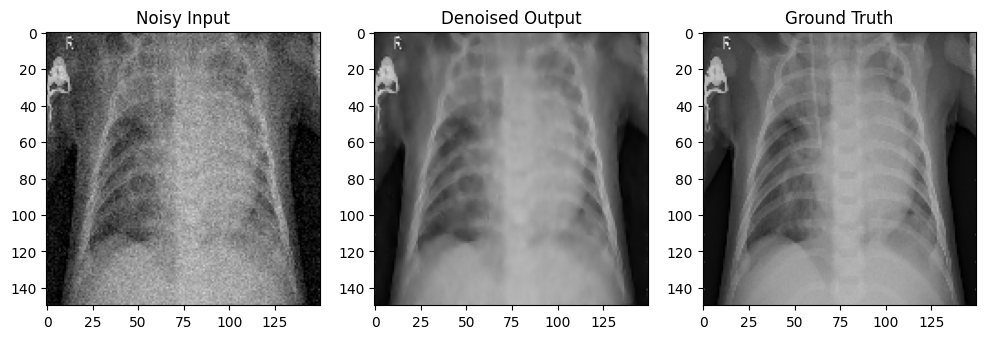

In [28]:
i = 10
visualize_sample(x_test_noise[i].squeeze(), denoise_img[0][i], x_test[i].squeeze())

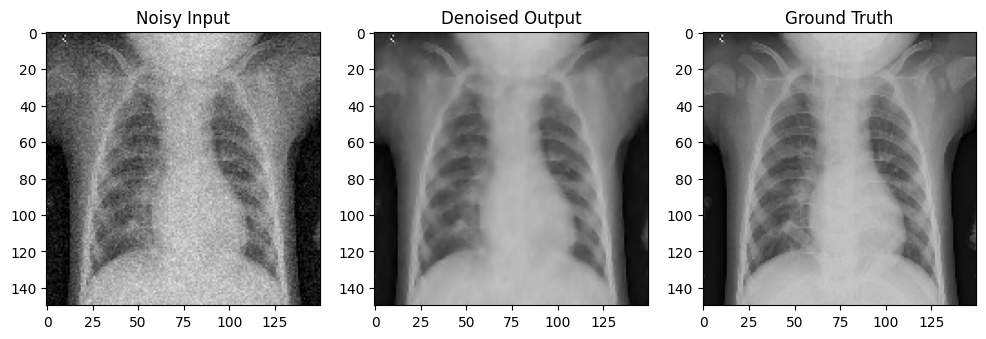

In [34]:
i = 16
visualize_sample(x_test_noise[i].squeeze(), denoise_img[0][i], x_test[i].squeeze())